In [ ]:
#This is a general classifcation template. The data used here is binary.. 
# a folder of all water NOAA images, and a folder of images that are not all water

In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics
import math

#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.9.1


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
#build data generators for training and validaton

# Define dirs and files
train_data_dir = '../data/train'
val_data_dir = '../data/val'
test_data_dir = '../data/test'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 90,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   shear_range = 0.45,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)


val_datagen = ImageDataGenerator(rescale =1./255.)
test_datagen = ImageDataGenerator(rescale =1./255.)


#set batch Size
batch_size = 16

#set Image size (RGB so imshape is 3)
pix_dim = 224
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    target_size = imsize)

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_directory(val_data_dir, 
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        target_size = imsize)
# Flow test images in batches 
test_generator =  test_datagen.flow_from_directory(test_data_dir, 
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        target_size = imsize)

Found 2134 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [4]:
#load or build model
##########

#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [7]:
#load or build model
##########

#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

base_model.trainable = False
# add a new classifcation layer

final_layer = base_model.get_layer('out_relu')
print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
x = layers.GlobalAveragePooling2D()(final_base_output )
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# traditioanlly this owuld be a final sigmoid layer for classification, 
# but we are runnign this as a cat model b/c of TF lite micro limitations..
x = layers.Dense(2,activation = "softmax")(x)       

model = Model(base_model.input, x) 
#############
model.summary()

shape of last layer is  (None, 7, 7, 1280)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [8]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')
TP = tf.keras.metrics.TruePositives()
TN = tf.keras.metrics.TrueNegatives()
FP = tf.keras.metrics.FalsePositives()
FN = tf.keras.metrics.FalseNegatives()


In [9]:
#build the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr = 3e-4),
              metrics = [acc_metric, TP, TN, FP, FN])

/usr/lib/python3/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [10]:
# define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'loss', 
                                             patience = 10, 
                                             restore_best_weights = True)

In [11]:
#train the model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    workers = 24,
                    max_queue_size = 30,
                    epochs= 30,
                    callbacks =[callbacks])

Epoch 1/30
134/134 [==============================] - 40s 220ms/step - loss: 0.7091 - acc: 0.7231 - true_positives: 1543.0000 - true_negatives: 1543.0000 - false_positives: 591.0000 - false_negatives: 591.0000 - val_loss: 0.4912 - val_acc: 0.8350 - val_true_positives: 167.0000 - val_true_negatives: 167.0000 - val_false_positives: 33.0000 - val_false_negatives: 33.0000
Epoch 2/30
134/134 [==============================] - 34s 209ms/step - loss: 0.5603 - acc: 0.7910 - true_positives: 1688.0000 - true_negatives: 1688.0000 - false_positives: 446.0000 - false_negatives: 446.0000 - val_loss: 0.3708 - val_acc: 0.8850 - val_true_positives: 177.0000 - val_true_negatives: 177.0000 - val_false_positives: 23.0000 - val_false_negatives: 23.0000
Epoch 3/30
134/134 [==============================] - 36s 252ms/step - loss: 0.5548 - acc: 0.7966 - true_positives: 1700.0000 - true_negatives: 1700.0000 - false_positives: 434.0000 - false_negatives: 434.0000 - val_loss: 0.3727 - val_acc: 0.8700 - val_true_

134/134 [==============================] - 36s 217ms/step - loss: 0.3375 - acc: 0.8936 - true_positives: 1907.0000 - true_negatives: 1907.0000 - false_positives: 227.0000 - false_negatives: 227.0000 - val_loss: 0.2572 - val_acc: 0.9550 - val_true_positives: 191.0000 - val_true_negatives: 191.0000 - val_false_positives: 9.0000 - val_false_negatives: 9.0000
Epoch 24/30
134/134 [==============================] - 39s 239ms/step - loss: 0.3518 - acc: 0.8899 - true_positives: 1899.0000 - true_negatives: 1899.0000 - false_positives: 235.0000 - false_negatives: 235.0000 - val_loss: 0.2420 - val_acc: 0.9400 - val_true_positives: 188.0000 - val_true_negatives: 188.0000 - val_false_positives: 12.0000 - val_false_negatives: 12.0000
Epoch 25/30
134/134 [==============================] - 38s 233ms/step - loss: 0.3527 - acc: 0.8946 - true_positives: 1909.0000 - true_negatives: 1909.0000 - false_positives: 225.0000 - false_negatives: 225.0000 - val_loss: 0.2308 - val_acc: 0.9600 - val_true_positives: 

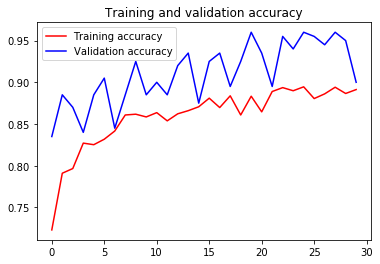

<Figure size 432x288 with 0 Axes>

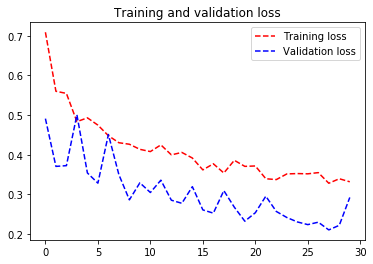

<Figure size 432x288 with 0 Axes>

In [12]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [13]:
#save the model
filepath = './models/MNv2Flood_cat'
model.save(filepath)

#load model
#model = tf.keras.models.load_model(filepath, compile = True)

INFO:tensorflow:Assets written to: ./models/MNv2Flood_cat/assets


INFO:tensorflow:Assets written to: ./models/MNv2Flood_cat/assets


In [14]:
model.evaluate(test_generator)

13/13 [==============================] - 12s 927ms/step - loss: 0.3711 - acc: 0.9000 - true_positives: 180.0000 - true_negatives: 180.0000 - false_positives: 20.0000 - false_negatives: 20.0000


[0.37110066413879395, 0.8999999761581421, 180.0, 180.0, 20.0, 20.0]

In [15]:
# #quantize

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]



num_calibration_steps = 1
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        # Get sample input data as a numpy array in a method of your choosing.
        ## Ideally we should do a validation calibration but we are using all of the training data for max acc
#         x =np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
        x =np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
        print(x.shape)
        yield [x]
converter.representative_dataset = representative_dataset_gen


converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

tflite_model = converter.convert()

with open('MNv2Flood_cat.tflite','wb') as f:
    f.write(tflite_model)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

# import pathlib

# tflite_models_dir = pathlib.Path("TFLmodels/")
# tflite_models_dir.mkdir(exist_ok=True, parents=True)


# tflite_model_file = tflite_models_dir/"MNv2Flood_cat.tflite"
# tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpmkq_10x7/assets


INFO:tensorflow:Assets written to: /tmp/tmpmkq_10x7/assets
/usr/lib/python3/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


(200, 224, 224, 3)
input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [17]:
NF =0
F = 0

for filename in os.listdir('../data/test/flooded/'):
    fp = '../data/test/flooded/' + filename
    print(filename)
    img = tf.keras.preprocessing.image.load_img(fp,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    test_im = np.expand_dims(img,axis=0)

    score = model.predict(test_im, verbose = 0)
    print(score)
    #print(np.round(score))
#     if np.round(score)==1:
#         print('not Flooded')
#         NF = NF +1
#     else:
#         print('flooded')
#         F = F +1
# print(F)
# print(NF)

CAM_BF_01_20220517000022.jpg
[[0.0154474 0.9845526]]
CAM_BF_01_20220519024221.jpg
[[0.3056636 0.6943364]]
CAM_BF_01_20211107015422.jpg
[[0.91120976 0.08879025]]
CAM_BF_01_20211108144222.jpg
[[0.9328387  0.06716133]]
CAM_BF_01_20220516013022.jpg
[[0.12004086 0.8799591 ]]
CAM_BF_01_20211108131822.jpg
[[0.9580443  0.04195573]]
CAM_BF_01_20211108153022.jpg
[[0.889287   0.11071293]]
CAM_BF_01_20220519033021.jpg
[[0.7364216  0.26357836]]
CAM_BF_01_20211206140622.jpg
[[0.31031156 0.6896885 ]]
CAM_BF_01_20211009144221.jpg
[[0.99468815 0.00531185]]
CAM_BF_01_20211206134822.jpg
[[0.7887559  0.21124412]]
CAM_BF_01_20220519035422.jpg
[[0.3150563  0.68494374]]
CAM_BF_01_20211107124222.jpg
[[0.9610001  0.03899995]]
CAM_BF_01_20220516003622.jpg
[[0.65128005 0.34872   ]]
CAM_BF_01_20211106150621.jpg
[[9.9975926e-01 2.4076796e-04]]
CAM_BF_01_20220116233022.jpg
[[9.9997616e-01 2.3812545e-05]]
CAM_BF_01_20211109143622.jpg
[[0.7226957 0.2773043]]
CAM_BF_01_20220516234822.jpg
[[0.01661459 0.98338544]]
CAM_

In [ ]:
NF =0
F = 0

for filename in os.listdir('../data/test/not_flooded/'):
    fp = '../data/test/not_flooded/' + filename
    print(filename)
    img = tf.keras.preprocessing.image.load_img(fp,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    test_im = np.expand_dims(img,axis=0)

    score = model.predict(test_im, verbose = 0)
    #print(score)
    #print(np.round(score))
    if np.round(score)==1:
        print('not Flooded')
        NF = NF +1
    else:
        print('flooded')
        F = F +1
        
print(F)
print(NF)